TLDR : in this notebook we compare the photometry of the same objects by the same pipeline at different epochs. Of course, some objects could be inherently variable, but the majority of objects isn not.

In [1]:
import astropy.visualization as vis
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import os
import numpy as np
import urllib.request
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table
from astropy.table import hstack
from astropy.table import vstack
from astropy import wcs
from itertools import product
from scipy.stats import binned_statistic as bs

## Find and process visits at same location but different epochs 

Given the fields that we already processed with LSST, could there be any other one that I could process that was taken at a similar location  ?


In [2]:
visit_density_dic = {'20':[611529,609754,525814,525900],
                     '15':[611970,525837,525838],
                     '10':[611969,525846,525879],
                     '5':[525904,525920]}   
stack_visit  = visit_density_dic.values()

# Load DECAPS image database 
image_database = '../raw_data/decaps_catalogs/imdb.fits'
imdb_hdu = fits.open(image_database)
imdb = Table(imdb_hdu[1].data)

# al

In [7]:
stack_visit  = []
for value in visit_density_dic.values():
    #stack_visit.append(value)
    stack_visit = np.append(value, stack_visit)
len(stack_visit)

12

In [8]:

# visit comes from dtacqnam 
x1 = len('/data_local/images/DTS/2016A-0327/DECam_00')
x2 = len('.fits.fz')
visit = [line[x1:-x2] for line in imdb['dtacqnam'].data.astype(str)]
imdb['visit'] = visit
decaps = imdb[[ 'visit','prodtype', 'exptime', 'mjd_obs', 
              'filterid', 'ra','dec', 'sb_name',  'magzero', 
               'catfname','dtnsanam'
              ]]


In [9]:
print(stack_visit)
stacks = stack_visit.astype(int).astype(str)

[ 525904.  525920.  611969.  525846.  525879.  611970.  525837.  525838.
  611529.  609754.  525814.  525900.]


In [10]:
stacks

array(['525904', '525920', '611969', '525846', '525879', '611970',
       '525837', '525838', '611529', '609754', '525814', '525900'],
      dtype='<U21')

In [11]:
stack_info = decaps[decaps['visit'] == stacks[0]]
for visit in stacks[1:]:
    rows = decaps['visit'] == visit
    stack_info = vstack([stack_info,decaps[rows]])

In [12]:
# Now cross-match the info table for fields that already got 
# processed with LSST against the entire rest of the imbd ...

# First, remove the 12 visits that we already processed so that they wouldn't be matched to 
# self ....
decaps_else = decaps[np.bitwise_not(np.in1d(decaps['visit'], stacks))]

choose_filter=  decaps_else['filterid'] == 'g.0000'
choose_exp = decaps_else['exptime'] > 90
decaps_ = decaps_else[choose_filter*choose_exp]
#decaps_

In [13]:
#decaps_else

In [14]:
# Next, match by coords


# express pixel coordinates as SkyCoord object, 
decaps_coords = SkyCoord(decaps_['ra'],decaps_['dec'], frame='icrs', 
                         unit='degree')

# express the decaps field coordinates as SkyCoord object ..
stack_coords = SkyCoord(ra = stack_info['ra'].data, dec = stack_info['dec'].data, 
                       unit='degree', frame='icrs')



idx, d2d, d3d = stack_coords.match_to_catalog_sky(decaps_coords)  

# stack the two catalogs 
stack_imdb = hstack([stack_info, decaps_[idx]])

# add column with distance to the nearest MAF pixel...
stack_imdb['d2d_deg'] = d2d.degree

In [15]:
mask_d = stack_imdb['d2d_deg'] < 0.1
mask_exp1 = stack_imdb['exptime_1'] > 90
mask  = mask_d * mask_exp1
stack_imdb[mask][['visit_1','visit_2', 'exptime_1', 'exptime_2']]


visit_1,visit_2,exptime_1,exptime_2
str6,str6,float64,float64
525904,527300,96.0,96.0
525920,527296,96.0,96.0
525846,530012,96.0,96.0
525879,530032,96.0,96.0
525837,527246,96.0,96.0
525838,527247,96.0,96.0
525814,529974,96.0,96.0
525900,529989,96.0,96.0


In [16]:
# The separation is within few days 
stack_imdb[mask]['mjd_obs_1'] -stack_imdb[mask]['mjd_obs_2']

-2.95992539
-2.9387678
-13.00447798
-12.98902574
-2.97701731
-2.97700361
-12.99238801
-12.91695244


In [29]:
stack_imdb[mask]['dtnsanam_2']
visit_info = stack_imdb[mask]

In [31]:
visit_info['density'] = [5,5,10,10,15,15,20,20]

In [32]:
# Save the info ...
visit_info.write('decaps_rms_different_epoch_fields.txt', format='ascii', overwrite=True)



Ok, found 8 pairs, two per density, of fields that were observed at different but close epochs

Need to save the ones we want as a votable ...

In [18]:
# from a file that has imaging, wtmap,  dqmask, select only desired rows ...
fname = 'rows_as_votable_1516932989_6863.vot.xml'  # imaging, dqmask ,wtmap 
import astropy.io.votable as vo

#table = parse_single_table(fname)
#decaps_all = table.to_table()
vo.is_votable(fname)
#fname = 'rows_as_votable_1516932680_713.vot.xml'
table = vo.parse_single_table(fname, invalid='mask')
decaps_rows = table.to_table()

In [19]:
select = np.in1d(decaps_rows['dtnsanam'].data.data.astype(str), 
                 stack_imdb[mask]['dtnsanam_2'].data.astype(str))



In [20]:
# Display what we have found ... 
# there should be 3*8 = 24 rows ... 
decaps_rows[select]['dtnsanam', 'prodtype',]

dtnsanam,prodtype
object,object
c4d_160317_001026_ori.fits,wtmap
c4d_160317_001026_ori.fits,dqmask
c4d_160317_001026_ori.fits,image
c4d_160317_001229_ori.fits,wtmap
c4d_160317_001229_ori.fits,image
c4d_160317_001229_ori.fits,dqmask
c4d_160317_012643_ori.fits,image
c4d_160317_012643_ori.fits,dqmask
c4d_160317_012643_ori.fits,wtmap


In [88]:
# save that list of archive filenames 
# as a VOTable to download 
# with secure get 
N = np.sum(select)
fname = 'decaps_NOAO_download_votable_'+str(N)+'.vot.xml'
decaps_rows[select].write(fname,format='votable',
                          overwrite=True)
print('We saved %d names to download as %s'%(N,fname))

We saved 24 names to download as decaps_NOAO_download_votable_24.vot.xml


In [24]:
decaps_rows[select]['dtnsanam']

c4d_160317_001026_ori.fits
c4d_160317_001026_ori.fits
c4d_160317_001026_ori.fits
c4d_160317_001229_ori.fits
c4d_160317_001229_ori.fits
c4d_160317_001229_ori.fits
c4d_160317_012643_ori.fits
c4d_160317_012643_ori.fits
c4d_160317_012643_ori.fits
c4d_160317_013249_ori.fits
c4d_160317_013249_ori.fits


Now I scp that table to NCSA,  ssh , and execute secure_get script... 

    scp decaps_NOAO_download_votable_24.vot.xml scichris@lsst-dev.ncsa.illinois.edu:/home/scichris/
    
    ssh scichris@lsst-dev01.ncsa.illinois.edu
    
    ./secure_get.sh decaps_NOAO_download_votable_24.vot.xml        

    mv c4d*ood*   noao_files/dqmask/
    mv c4d*ooi*   noao_files/instcal/
    mv c4d*oow*   noao_files/wtmap/

    source /ssd/lsstsw/stack/loadLSST.bash 
    
    setup obs_decam 
    
    ingestImagesDecam.py repo/ noao_files/instcal/c4d_1603*.fits.fz

Now process, starting from the lowest density ... 

    tmux 
    processCcd.py repo --rerun proc20perc  --id visit=529974^529989  -C config_processccd.py --clobber-config --clobber-versions  > proct20.log
    ctrl+d, b to detach 
    
    tmux , etc 
    processCcd.py repo --rerun proc15perc  --id visit=527247^527246  -C config_processccd.py --clobber-config --clobber-versions  > proct15.log

    processCcd.py repo --rerun proc10perc  --id visit=530032^530012  -C config_processccd.py --clobber-config --clobber-versions  > proct10.log
    
    processCcd.py repo --rerun proc5perc  --id visit=527296^527300  -C config_processccd.py --clobber-config --clobber-versions  > proct05.log
    
Keep checking progress :
    
    wc -l proct*
    
    

    

## Compare two epochs

In [33]:
# Read in the info about selected visist ...
visit_info = Table.read('decaps_rms_different_epoch_fields.txt', format='ascii')

In [36]:
visit_info[['visit_1', 'mjd_obs_1', 'visit_2', 'mjd_obs_2', 'density']]

visit_1,mjd_obs_1,visit_2,mjd_obs_2,density
int64,float64,int64,float64,int64
525904,57461.1028366,527300,57464.062762,5
525920,57461.1197723,527296,57464.0585401,5
525846,57461.0384352,530012,57474.0429131,10
525879,57461.0758847,530032,57474.0649105,10
525837,57461.0284634,527246,57464.0054807,15
525838,57461.0299226,527247,57464.0069262,15
525814,57461.0044199,529974,57473.9968079,20
525900,57461.0985956,529989,57474.0155481,20


In [ ]:
# Use the image database 
image_database = '../raw_data/decaps_catalogs/imdb.fits'
imdb_hdu = fits.open(image_database)
imdb = Table(imdb_hdu[1].data)

In [40]:
#for density in densities : 
density = 20
rows = visit_info['density'] == density 
visit_t1 = visit_info[rows]['visit_1'].data
visit_t2 = visit_info[rows]['visit_2'].data
# for i in range len(visit_t1)
i = 0
print('Comparing')


In [58]:
#visit_t1

array([525814, 525900])

In [206]:
# Loop over visits ...
# Use the same functions to read in hte data
# as in N1_decaps_lsst_crossmatch ... 

def read_decaps(visit, imdb,save_tables=True, return_info = True):
    #####################################################################################
    ################################### use all DECAPS info  ############################
    #####################################################################################
    # read in the DECAPS single-epoch catalog ...
    singleDir = '../raw_data/decaps_catalogs/single_epoch/'
    cat_name = imdb[imdb['expnum'] == visit]['catfname'].data[0]
    file_name  = singleDir + cat_name
    print('The single-band catalog name corresponding to visit %d is %s' %(visit, cat_name))

    # the cat name is based on the image name ... 
    #image_name = 'c4d_170122_055542_ooi_g'
    #cat_name = image_name + '_v1.cat.fits'
    singleDir = '../raw_data/decaps_catalogs/single_epoch/'
    file_name  = singleDir + cat_name

    # check if the catalog already exists
    if cat_name not in  os.listdir(singleDir) : 
        print('Downloading the catalog...')# if not, download it ...
        url = 'https://faun.rc.fas.harvard.edu/decaps/release/cat/' + cat_name
        urllib.request.urlretrieve(url, file_name)

    #open the decaps catalog ...
    decaps_hdu = fits.open(file_name)

    # make a dictionary of ccdnumber vs hduposition
    ccd_name_dict = {}
    cat_decaps_dict = {}
    for i in range(1,len(decaps_hdu[:])) : 
        if 'IMAGE' in decaps_hdu[i].header['XTENSION'] :
            ccdnum = decaps_hdu[i].header['CCDNUM']
            detpos = decaps_hdu[i].header['DETPOS']
            ccd_name_dict[ccdnum] = detpos
            cat_decaps_dict[ccdnum] = int(i+2)

    # obtain the calibrated decaps zeropoint ...
    #mjd_obs = decaps_hdu[0].header['MJD-OBS']
    # m = zps_table['mjd_obs'] == mjd_obs
    #decaps_zeropoint = zps_table['zp'][m].data[0]

    # use the decaps single-epoch zeropoint 
    decaps_zeropoint = decaps_hdu[0].header['MAGZERO']  
    print('decaps calibrated zeropoint is ', decaps_zeropoint)

    # Make a Table from the ccd dictionary 
    dict_ccd = {}
    dict_ccd['ccdnum'] = ccd_name_dict.keys()
    dict_ccd['ccdname'] = ccd_name_dict.values()
    dict_ccd['hdupos'] = cat_decaps_dict.values()

    a = list(dict_ccd['ccdnum'])
    b = list(dict_ccd['ccdname'])
    c = list(dict_ccd['hdupos'])

    t = Table([a, b, c], names=('ccdnum', 'ccdname', 'hdupos'))

    # read in all the info from the decaps single-epoch catalog
    arr = { 'decaps_mag':[],'decaps_magerr':[]} #,'decaps_ra':[],
           #'decaps_dec':[], 'decaps_flags':[]}
    decaps_stack = Table(arr, names = ('decaps_mag', 'decaps_magerr'))#,
                              #          'decaps_ra', 'decaps_dec', 
                              #          'decaps_flags', 'decaps_x',
                              #        'decaps_y', 'decaps_ccd'),
                              #  dtype = ('f8', 'f8','f8', 'f8', 'i8'))

    # we don't want to use ccd31 because of unstable amplifier ...
    ccds = np.array(list(ccd_name_dict.keys()))
    ccd_numbers = ccds[ccds != 31 ]
    print('Reading DECAPS src catalogs looping over CCDs')
    N_total_sources = 0
    N_removed_flags = 0
    N_removed_neg_flux=0
    N_removed_low_SN=0
    N_removed_total=0

    for ccd_number  in ccd_numbers :
        #print('Processing ccd ', ccd_number)
        ccdnum = str(ccd_number).zfill(2)

        # read in the DECAPS catalog from the HDU 
        hdupos = cat_decaps_dict[ccd_number]
        ccd_data =  Table(decaps_hdu[hdupos].data) 
        flux = ccd_data['flux'].data
        fluxErr = ccd_data['dflux'].data
        flags = ccd_data['flags'].data
        N_total_sources += len(flags)
        
        # only consider positive fluxes... 
        mask_neg_fluxes = flux > 0
        N_removed_neg_flux += np.sum(~mask_neg_fluxes)
        
        # mask low signal to noise sources .... 
        mask_low_sn = (flux / fluxErr ) > 5 
        N_removed_low_SN += np.sum(~mask_low_sn)
        
        # Using the decaps flags information, clean the DECAPS data 
        mask_decaps_filter = 2**1+  2**3+  2**4+  2**5+  2**6+  2**8+  2**20+  2**22
        mask_bad_flags = np.bitwise_not(flags & mask_decaps_filter > 0)
        N_removed_flags += np.sum(~mask_bad_flags)
        
        # combine the flags....
        mask_total = mask_neg_fluxes * mask_low_sn * mask_bad_flags
        N_removed_total += np.sum(~mask_total) 
    
        fluxG = flux[mask_total]
        fluxErrG = fluxErr[mask_total]
        ccd_decaps_good = ccd_data[mask_total]

        ccd_decaps_good['decaps_mag'] = -2.5 * np.log10(fluxG) + decaps_zeropoint
        ccd_decaps_good['decaps_magerr'] = (5.0 / (2*np.log(10))) * (fluxErrG / fluxG)

        # keep only the relevant info
        ccd_decaps = ccd_decaps_good[['decaps_mag','decaps_magerr','ra','dec', 
                                     'flags','x','y']]

        # add ccdnum info, 
        ccd_decaps['decaps_ccdnum'] = ccd_number

        # change the column names ... 
        ccd_decaps.rename_column('flags', 'decaps_flags')
        ccd_decaps.rename_column('ra', 'decaps_ra')
        ccd_decaps.rename_column('dec', 'decaps_dec')
        ccd_decaps.rename_column('x', 'decaps_x')
        ccd_decaps.rename_column('y', 'decaps_y')

        # add this ccd to a stack of all CCDs 
        decaps_stack = vstack([decaps_stack, ccd_decaps])

    print('Done stacking ')
    print('All source count ', N_total_sources )
    print('Flags masks bits 1,3,4,5,6,8,20,22 remove ',N_removed_flags)
    print('Negative fluxes remove ', N_removed_neg_flux)
    print('S/N <5 remove ', N_removed_low_SN )
    print('In total, we remove ', N_removed_total)
    print('Done')

    visit_info = {'N_start' : N_total_sources, 
                  'N_removed_flags':N_removed_flags,
                  'N_removed_negFlux':N_removed_neg_flux,
                 'N_removed_lowSN':N_removed_low_SN,
                 'N_removed_total':N_removed_total,
                  'N_clean' : len(decaps_stack)
                 }
    
    decaps_clean = decaps_stack   
    
    if save_tables is True : 
        fname = 'decaps_clean_'+str(visit)+'.txt'
        print('Saving clean DECAPS catalog as ', fname)
        decaps_clean.write(fname, format='ascii', overwrite=True)
        
        return decaps_clean, ccd_numbers
    
    if return_info is True : 
        return visit_info, ccd_numbers


def read_lsst(visit, ccd_numbers, save_tables=True, return_info=True):
    #####################################################################################
    ################################### use all LSST info  ############################
    #####################################################################################

    outDir = '../data_products/LSST_Stack_processing/DECam/'+str(visit)+'/'

    # first check calexp for zero point magnitude
    # it is exactly the same for all CCDs in a mosaic 
    calexp_files = os.listdir(outDir+'calexp/')
    calexp_hdu = fits.open(outDir+'calexp/' + calexp_files[0])
    lsst_zeropoint = calexp_hdu[0].header['MAGZERO']
    print('\nThe LSST- measured zeropoint for decam is %f'%lsst_zeropoint)

    arr = {'lsst_mag':[], 'lsst_magerr':[],'lsst_ra':[],'lsst_dec':[]
          }
    lsst_stack = Table(arr, names=('lsst_mag', 'lsst_magerr',
                                   'lsst_ra', 'lsst_dec'),
                 dtype=('f8', 'f8','f8', 'f8'))  
    N_total_sources = 0
    N_removed_flags = 0
    N_removed_neg_flux=0
    N_removed_low_SN=0
    N_removed_total=0
    for ccd_number  in ccd_numbers :
        #print('Processing ccd ', ccd_number)
        ccdnum = str(ccd_number).zfill(2)

        fname = 'src-0'+str(visit)+'_'+ccdnum+'.fits'
        hdu = fits.open(outDir +'src/'+ fname)

        # convert to an AstroPy table 
        ccd_data = Table(hdu[1].data)
        flux = ccd_data['base_PsfFlux_flux'].data
        fluxErr = ccd_data['base_PsfFlux_fluxSigma'].data
        flags = Table(ccd_data['flags'])
        N_total_sources += len(flags)
        
        # remove sources that have either of this flags 'on'
        # 61: flagEdge   67: flagInterpolatedCenter 
        f1 = flags['col'+str(61)] 
        f2 = flags['col'+str(67)] 
        mask_bad_flags = np.bitwise_not(f1 | f2) 
        N_removed_flags += np.sum(~mask_bad_flags)
        
        # only consider positive fluxes... 
        mask_neg_fluxes = flux > 0
        N_removed_neg_flux += np.sum(~mask_neg_fluxes)
    
        # mask low signal to noise sources .... 
        mask_low_sn = (flux / fluxErr ) > 5 
        N_removed_low_SN += np.sum(~mask_low_sn)
        
        # combine the flags....
        mask_total = mask_neg_fluxes * mask_low_sn * mask_bad_flags
        N_removed_total += np.sum(~mask_total) 
        
        
        ccd_lsst_good = ccd_data[mask_total]

        fluxG = ccd_lsst_good['base_PsfFlux_flux']
        fluxErrG =  ccd_lsst_good['base_PsfFlux_fluxSigma'].data
        ccd_lsst_good['lsst_mag'] = -2.5* np.log10(fluxG)  + lsst_zeropoint
        ccd_lsst_good['lsst_magerr'] = (5.0 / (2*np.log(10))) * (fluxErrG / fluxG)    

        # rename columns 
        ccd_lsst_good.rename_column('coord_ra', 'lsst_ra')
        ccd_lsst_good.rename_column('coord_dec', 'lsst_dec')

        # keep only most relevant info... 
        ccd_lsst  =  ccd_lsst_good[['lsst_mag', 'lsst_magerr','lsst_ra', 'lsst_dec']] 

        # add a column saying from which ccd these sources come from....
        ccd_lsst['ccdnum'] = ccd_number

        # add to the stack
        lsst_stack    = vstack([lsst_stack ,ccd_lsst] )

    print('All source count ', N_total_sources )
    print('Flags index 61,67 remove ',N_removed_flags)
    print('Negative fluxes remove ', N_removed_neg_flux)
    print('S/N <5 remove ', N_removed_low_SN )
    print('In total, we remove ', N_removed_total)
    print('Done')
    lsst_clean = lsst_stack
    
    visit_info = {'N_start' : N_total_sources, 
              'N_removed_flags':N_removed_flags,
              'N_removed_negFlux':N_removed_neg_flux,
             'N_removed_lowSN':N_removed_low_SN,
             'N_removed_total':N_removed_total,
              'N_clean' : len(lsst_stack)
             }
        
    if save_tables is True : 
        fname = 'lsst_clean_'+str(visit)+'.txt'
        print('Saving clean LSST catalog as ', fname)
        lsst_clean.write(fname, format='ascii', overwrite=True)
        
        return lsst_clean
    
    if return_info is True :
        return visit_info
    



**Save just the statistics about all visits **

combine both old and 'new' : the epoch2 visits...

In [186]:
imdb_maf = Table.read('decapsIMDB_MAF_table', format='ascii')

In [203]:
imdb_maf[:4]

visit,prodtype,exptime,mjd_obs,filterid,ra,dec,sb_name,magzero,catfname,dtnsanam,source_density,ra_rad,dec_rad,N_px_greater,frac_greater,d2d_deg
int64,str5,float64,float64,str6,float64,float64,str31,float64,str35,str26,float64,float64,float64,float64,float64,float64
525807,image,5.0,57460.9927059,r.0000,96.1841,-28.77976,c4d_160313_235023_ooi_r_v1.fits,26.832,c4d_160313_235023_ooi_r_v1.cat.fits,c4d_160313_235023_ori.fits,22248.0,1.68124294352,-0.499705040759,16103.0,0.415196988449,0.195167667822
525808,image,96.0,57460.9969294,g.0000,100.0008,-26.92384,c4d_160313_235804_ooi_g_v1.fits,29.646,c4d_160313_235804_ooi_g_v1.cat.fits,c4d_160313_235804_ori.fits,29196.0,1.74260217504,-0.464433821075,13913.0,0.35873040429,0.343651151172
525809,image,96.0,57460.998373,g.0000,99.83377,-27.073,c4d_160314_000006_ooi_g_v1.fits,29.623,c4d_160314_000006_ooi_g_v1.cat.fits,c4d_160314_000006_ori.fits,29196.0,1.74260217504,-0.464433821075,13913.0,0.35873040429,0.46298782973
525810,image,96.0,57460.9998095,g.0000,100.1685,-27.07277,c4d_160314_000215_ooi_g_v1.fits,29.629,c4d_160314_000215_ooi_g_v1.cat.fits,c4d_160314_000215_ori.fits,29232.0,1.75487402134,-0.476119060912,13907.0,0.35857570132,0.395077683453


In [256]:
# new visits 
visits = []
visits.append(visit_info['visit_1'].data)
visits.append(visit_info['visit_2'].data)
visits = np.array(visits).flatten()

# old visits 
visit_density_dic = {'20':[611529,609754,525814,525900],
                     '15':[611970,525837,525838],
                     '10':[611969,525846,525879],
                     '5':[525904,525920]}  
for value in visit_density_dic.values():
    visits = np.append(value,visits)

unique_visits = np.unique(visits)

In [257]:
len(unique_visits)

20

In [259]:
# Consider reading in and cleaning all visits : 
# store the count of object at each stage.. 

dic =  {}
for visit in unique_visits:
    dic[visit] = {}
    
for visit in unique_visits : 
    
    visit_stat_decaps, ccd_numbers = read_decaps(visit,imdb,save_tables=False,
                                                 return_info=True)
    dic[visit]['decaps'] = visit_stat_decaps
    
    visit_stat_lsst  = read_lsst(visit,ccd_numbers, save_tables=False,
                                 return_info=True)
    dic[visit]['lsst'] = visit_stat_lsst

The single-band catalog name corresponding to visit 525814 is c4d_160314_000848_ooi_g_v1.cat.fits
decaps calibrated zeropoint is  29.4545
Reading DECAPS src catalogs looping over CCDs
Done stacking 
All source count  200562
Flags masks bits 1,3,4,5,6,8,20,22 remove  4481
Negative fluxes remove  61
S/N <5 remove  882
In total, we remove  4938
Done

The LSST- measured zeropoint for decam is 29.454500
All source count  235307
Flags index 61,67 remove  16811
Negative fluxes remove  1097
S/N <5 remove  49901
In total, we remove  50333
Done
The single-band catalog name corresponding to visit 525837 is c4d_160314_004325_ooi_g_v1.cat.fits
decaps calibrated zeropoint is  30.011
Reading DECAPS src catalogs looping over CCDs
Done stacking 
All source count  425261
Flags masks bits 1,3,4,5,6,8,20,22 remove  6791
Negative fluxes remove  181
S/N <5 remove  1360
In total, we remove  7437
Done

The LSST- measured zeropoint for decam is 30.011000
All source count  393879
Flags index 61,67 remove  22350

decaps calibrated zeropoint is  29.734
Reading DECAPS src catalogs looping over CCDs
Done stacking 
All source count  638179
Flags masks bits 1,3,4,5,6,8,20,22 remove  9776
Negative fluxes remove  256
S/N <5 remove  1893
In total, we remove  10964
Done

The LSST- measured zeropoint for decam is 29.734000
All source count  486203
Flags index 61,67 remove  23112
Negative fluxes remove  782
S/N <5 remove  50220
In total, we remove  52098
Done
The single-band catalog name corresponding to visit 609754 is c4d_170117_064542_ooi_i_v1.cat.fits
decaps calibrated zeropoint is  29.122
Reading DECAPS src catalogs looping over CCDs
Done stacking 
All source count  474355
Flags masks bits 1,3,4,5,6,8,20,22 remove  10034
Negative fluxes remove  334
S/N <5 remove  2483
In total, we remove  11677
Done

The LSST- measured zeropoint for decam is 29.122000
All source count  490143
Flags index 61,67 remove  26233
Negative fluxes remove  812
S/N <5 remove  61507
In total, we remove  67069
Done
The single-ba

In [260]:
len(unique_visits)

20

In [262]:
len(dic.keys())

20

In [263]:
arr = {'visit':np.zeros_like(unique_visits, dtype=int),
      'N_start':np.zeros_like(unique_visits, dtype=int),
      'N_removed_flags':np.zeros_like(unique_visits, dtype=int),
      'N_removed_negFlux':np.zeros_like(unique_visits, dtype=int),
      'N_removed_lowSN':np.zeros_like(unique_visits, dtype=int),
      'N_removed_total':np.zeros_like(unique_visits, dtype=int),
      'N_clean':np.zeros_like(unique_visits, dtype=int),
      'density':np.zeros_like(unique_visits, dtype=float),
       'MAFnumber':np.zeros_like(unique_visits, dtype=int)
      }

visit_table_lsst = Table(arr)
visit_table_decaps = Table(arr)

In [266]:
#imdb_maf

In [267]:
i = 0 
for visit in dic.keys():
    visit_table_lsst['visit'][i] = visit
    visit_table_lsst['N_start'][i] = dic[visit]['lsst']['N_start']
    visit_table_lsst['N_removed_flags'][i] = dic[visit]['lsst']['N_removed_flags']
    visit_table_lsst['N_removed_negFlux'][i] = dic[visit]['lsst']['N_removed_negFlux']
    visit_table_lsst['N_removed_lowSN'][i] = dic[visit]['lsst']['N_removed_lowSN']
    visit_table_lsst['N_removed_total'][i] = dic[visit]['lsst']['N_removed_total']
    visit_table_lsst['N_clean'][i] = dic[visit]['lsst']['N_clean']
    visit_table_lsst['density'][i] = imdb_maf[imdb_maf['visit'] == visit]['frac_greater'][0]
    visit_table_lsst['MAFnumber'][i] = imdb_maf[imdb_maf['visit'] == visit]['source_density'][0]
    i += 1 
    
i =0 
for visit in dic.keys():
    visit_table_decaps['visit'][i] = visit
    visit_table_decaps['N_start'][i] = dic[visit]['decaps']['N_start']
    visit_table_decaps['N_removed_flags'][i] = dic[visit]['decaps']['N_removed_flags']
    visit_table_decaps['N_removed_negFlux'][i] = dic[visit]['decaps']['N_removed_negFlux']
    visit_table_decaps['N_removed_lowSN'][i] = dic[visit]['decaps']['N_removed_lowSN']
    visit_table_decaps['N_removed_total'][i] = dic[visit]['decaps']['N_removed_total']
    visit_table_decaps['N_clean'][i] = dic[visit]['decaps']['N_clean']
    visit_table_decaps['density'][i] = imdb_maf[imdb_maf['visit'] == visit]['frac_greater'][0]
    visit_table_decaps['MAFnumber'][i] = imdb_maf[imdb_maf['visit'] == visit]['source_density'][0]
    i += 1 

visit,N_start,N_removed_flags,N_removed_negFlux,N_removed_lowSN,N_removed_total,N_clean,density,MAFnumber,N_per_sq_deg,N_dimless
int64,int64,int64,int64,int64,int64,int64,float64,int64,float64,float64
530012,160406,15210,1148,50521,50760,109646,0.105533209571,203040,39384.7736711,0.00152754216825
525846,167582,15247,1075,50874,51155,116427,0.105533209571,203040,41820.5045711,0.00162201222136
525900,171337,15037,1031,45765,45984,125353,0.199360561056,79632,45026.7181109,0.00174636551645
529989,182933,15910,1055,48065,48185,134748,0.199360561056,79632,48401.3961533,0.0018772527232
529974,228849,16842,791,43921,44364,184485,0.204826732673,76572,66266.895014,0.0025701677846
525814,235307,16811,1097,49901,50333,184974,0.204826732673,76572,66442.5435039,0.00257698032787
527247,264383,15283,1034,37357,37754,226629,0.155682755776,116676,81404.9930896,0.00315730034884
527246,319929,18136,1137,46096,46728,273201,0.157487623762,114588,98133.6259573,0.00380612195528
611970,377917,26716,831,80053,80620,297297,0.115073226073,178992,106788.893877,0.00414181733939


In [275]:
area_per_ccd = (2048 * 4096 * 0.27 * 0.27) / (3600 * 3600) # arcsec to degrees 
area_per_visit = len(ccd_numbers) * area_per_ccd
print('Area per DECAPS visit is ', area_per_visit, ' sq degrees')

Area per DECAPS visit is  2.7839692800000004  sq degrees


In [276]:
# Number per sq degree 
visit_table_lsst['N_per_sq_deg'] = visit_table_lsst['N_clean'] / area_per_visit
visit_table_decaps['N_per_sq_deg'] = visit_table_decaps['N_clean'] / area_per_visit

#( N_sources / arcsec_sq ) * PSF,
# we assume that diameter of the psf effective area is ~ 0.8 FWHM
# thus radius is  0.4 arcsec
# therefore the area of the psf is  pi * 0.4 ^2.0 arcsec sq
psf_radius = 0.4 
visit_table_lsst['N_dimless'] = (visit_table_lsst['N_per_sq_deg'] / (3600*3600) ) \
    *np.pi * psf_radius*psf_radius
visit_table_decaps['N_dimless'] = (visit_table_decaps['N_per_sq_deg'] / (3600*3600) )\
    *np.pi * psf_radius*psf_radius



In [318]:
# Order by the actual number of sources... 
dic

{525814: {'decaps': {'N_clean': 195624,
   'N_removed_flags': 4481,
   'N_removed_lowSN': 882,
   'N_removed_negFlux': 61,
   'N_removed_total': 4938,
   'N_start': 200562},
  'lsst': {'N_clean': 184974,
   'N_removed_flags': 16811,
   'N_removed_lowSN': 49901,
   'N_removed_negFlux': 1097,
   'N_removed_total': 50333,
   'N_start': 235307}},
 525837: {'decaps': {'N_clean': 417824,
   'N_removed_flags': 6791,
   'N_removed_lowSN': 1360,
   'N_removed_negFlux': 181,
   'N_removed_total': 7437,
   'N_start': 425261},
  'lsst': {'N_clean': 337151,
   'N_removed_flags': 22350,
   'N_removed_lowSN': 55703,
   'N_removed_negFlux': 1040,
   'N_removed_total': 56728,
   'N_start': 393879}},
 525838: {'decaps': {'N_clean': 354278,
   'N_removed_flags': 6057,
   'N_removed_lowSN': 978,
   'N_removed_negFlux': 112,
   'N_removed_total': 6515,
   'N_start': 360793},
  'lsst': {'N_clean': 316812,
   'N_removed_flags': 19984,
   'N_removed_lowSN': 53794,
   'N_removed_negFlux': 1045,
   'N_removed_t

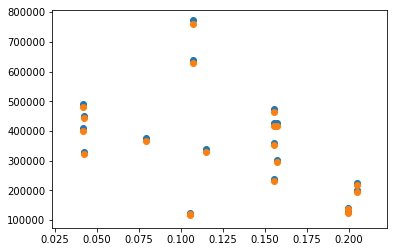

In [282]:
plt.scatter(visit_table_decaps['density'], visit_table_decaps['N_start'])
plt.scatter(visit_table_decaps['density'], visit_table_decaps['N_clean'])

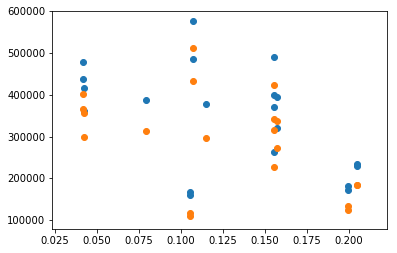

In [283]:
plt.scatter(visit_table_lsst['density'], visit_table_lsst['N_start'])
plt.scatter(visit_table_lsst['density'], visit_table_lsst['N_clean'])

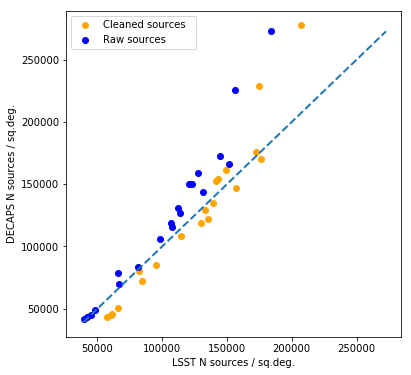

In [308]:

fig,ax = plt.subplots(1,1,figsize=(6,6))

for n,color,label in zip(['start','clean'],['orange','blue'],
                        ['Cleaned sources  ','Raw sources  ']):
    lsst = visit_table_lsst['N_'+n] / area_per_visit
    decaps = visit_table_decaps['N_'+n] / area_per_visit
    x = np.linspace(min(lsst),max(decaps),100)
    ax.scatter(lsst, decaps, c=color, label=label)
ax.plot(x,x, ls='--',lw=2)

ax.set_ylabel('DECAPS N sources / sq.deg.')
ax.set_xlabel('LSST N sources / sq.deg.')
#ax[1].set_xlabel('LSST N sources / sq.deg.')
ax.legend()
plt.savefig('decaps_lsst_source_count.png', bbox_inches='tight')

In [312]:

visit_table_decaps.sort('N_clean')
visit_table_decaps.write('visits_table_decaps.txt', format='latex',
                        overwrite='True')

In [320]:
dic[visit]['lsst']

{'N_clean': 184974,
 'N_removed_flags': 16811,
 'N_removed_lowSN': 49901,
 'N_removed_negFlux': 1097,
 'N_removed_total': 50333,
 'N_start': 235307}

In [328]:
i = 0 
arr = {'visit':np.zeros_like(unique_visits, dtype=int),
      'N_start':np.zeros_like(unique_visits, dtype=int),
      'N_removed_flags':np.zeros_like(unique_visits, dtype=int),
      'N_removed_negFlux':np.zeros_like(unique_visits, dtype=int),
      'N_removed_lowSN':np.zeros_like(unique_visits, dtype=int),
      'N_removed_total':np.zeros_like(unique_visits, dtype=int),
      'N_clean':np.zeros_like(unique_visits, dtype=int),
      'density':np.zeros_like(unique_visits, dtype=float),
       'MAFnumber':np.zeros_like(unique_visits, dtype=int)
      }

visit_table_lsst = Table(arr)

for visit in dic.keys():
    visit_table_lsst['visit'][i] = visit
    visit_table_lsst['N_start'][i] = dic[visit]['lsst']['N_start']
    visit_table_lsst['N_removed_flags'][i] = dic[visit]['lsst']['N_removed_flags']
    visit_table_lsst['N_removed_negFlux'][i] = dic[visit]['lsst']['N_removed_negFlux']
    visit_table_lsst['N_removed_lowSN'][i] = dic[visit]['lsst']['N_removed_lowSN']
    visit_table_lsst['N_removed_total'][i] = dic[visit]['lsst']['N_removed_total']
    visit_table_lsst['N_clean'][i] = dic[visit]['lsst']['N_clean']
    visit_table_lsst['density'][i] = imdb_maf[imdb_maf['visit'] == visit]['frac_greater'][0].round(3)
    visit_table_lsst['MAFnumber'][i] = imdb_maf[imdb_maf['visit'] == visit]['source_density'][0]
    i += 1 
    
# Number per sq degree 
visit_table_lsst['N_per_sq_deg'] = np.array(visit_table_lsst['N_clean'] / area_per_visit).astype(int)



In [330]:
area_per_visit

2.7839692800000004

In [329]:

visit_table_lsst.sort('N_clean')

visit_table_lsst.rename_column('N_start', 'N raw')
visit_table_lsst.rename_column('N_removed_flags', 'N bad flags')
visit_table_lsst['N low SN']= visit_table_lsst['N_removed_negFlux']+\
    visit_table_lsst['N_removed_lowSN']
visit_table_lsst.rename_column('N_removed_total', 'N removed')
visit_table_lsst.rename_column('N_clean', 'N final')
visit_table_lsst.rename_column('density', 'MAF density')
visit_table_lsst.rename_column('MAFnumber', 'MAF N sources sq.deg.')
visit_table_lsst.rename_column('N_per_sq_deg', 'N sources sq.deg.')

sel_cols = ['visit','N raw','N bad flags','N removed', 'N final','MAF density',
           'MAF N sources sq.deg.','N sources sq.deg.']
visit_table_lsst[sel_cols].write('visits_table_lsst.txt', format='latex',
                       overwrite='True')

### Save LSST, DECAPS clean catalogs 

In [99]:
visits = []
visits.append(visit_info['visit_1'].data)
visits.append(visit_info['visit_1'].data)
visits = np.array(visits).flatten()

In [105]:
for visit in visits : 
    print('\n Working on visit ', visit)
    if 'decaps_clean_'+str(visit)+'.txt' not in os.listdir() : 
        decaps_clean, ccd_numbers = read_decaps(visit,imdb)
    if 'lsst_clean_'+str(visit)+'.txt' not in os.listdir() : 
        lsst_clean = read_lsst(visit,ccd_numbers)


 Working on visit  525904

 Working on visit  525920

 Working on visit  525846

 Working on visit  525879

 Working on visit  525837

 Working on visit  525838

 Working on visit  525814

 Working on visit  525900

 Working on visit  525904

 Working on visit  525920

 Working on visit  525846

 Working on visit  525879

 Working on visit  525837

 Working on visit  525838

 Working on visit  525814

 Working on visit  525900


## LSST-LSST , DECAPS-DECAPS: cross-match different epochs

For each pair at different epochs, load the clean catalogs from LSST or DECAPS. Cross-match. Save as cross-matched catalogs. 

In [112]:
## Match DECAPS to DECAPS, or LSST to LSST 
def cross_match_epochs(visit1,visit2, source='lsst',save_tables=False):

    # Match sources from  one catalog  to another : 
    # we are matching two visits of the same region on
    # the sky, in the same filter, and with the same exposure time, 
    # processed either by the DECAPS pipeline,or the LSST pipeline...
    print('Epoch1 is ', visit1, ' epoch2 is ', visit2)
    
    
    # Load the cleaned catalogs
    if source is 'lsst': 
        print('Loading LSST catalogs ')
        pre = 'lsst'
    else:
        print('Loading DECAPS catalogs')
        pre = 'decaps'
        
    epoch1 = Table.read(pre+'_clean_'+str(visit1)+'.txt', format='ascii')
    epoch2 = Table.read(pre+'_clean_'+str(visit2)+'.txt', format='ascii')
    
    print('There are %d  sources  in epoch1 and %d sources in epoch2'%(len(epoch1),
                                                          len(epoch2))
         )
    
    # main difference between LSST and DECAPS is that 
    # DECAPS ra,dec is in degrrees, and :SST is in radians
    if source is 'lsst': 
        print('Matching LSST catalogs ')
        # lsst1 coordinates: in radians ! 
        epoch1_coord = SkyCoord(ra  = epoch1[pre+'_ra']*u.radian, 
                                dec = epoch1[pre+'_dec']*u.radian)  

        # lsst2 coordinates : in radians ! 
        epoch2_coord = SkyCoord(ra  = epoch2[pre+'_ra']*u.radian, 
                                dec = epoch2[pre+'_dec']*u.radian)  

    else : 
        print('Matching DECAPS catalogs')
        epoch1_coord = SkyCoord(ra = epoch1[pre+'_ra']*u.degree, 
                                 dec= epoch1[pre+'_dec']*u.degree)  
        epoch2_coord = SkyCoord(ra = epoch2[pre+'_ra']*u.degree, 
                                 dec= epoch2[pre+'_dec']*u.degree) 

    # indices are into epoch2 catalog
    idx, d2d, d3d = epoch1_coord.match_to_catalog_sky(epoch2_coord)  

    # stack the two catalogs 
    epoch12 = hstack([epoch1 ,epoch2[idx]],
                     table_names=['1','2']  )
    
    # select matches within 0.5 arcsec...
    cut_arcsec = 0.5 
    mask_arcsec = d2d.arcsec < cut_arcsec
    epoch12['d2darcsec'] = d2d.arcsec

    # matches within 0.5 mag from one another ... 
    dmag = epoch12[pre+'_mag_2'] - epoch12[pre+'_mag_1']
    cut_mag = 0.5
    mask_mag = abs(dmag) < cut_mag
    mask_comb  = mask_arcsec * mask_mag

    print(' %d epoch1 srcs have an epoch2 match within %.1f arcsec'%(
        np.sum(mask_arcsec), cut_arcsec)
         )
    print(' %d epoch1 srcs have a  epoch2 match within %.1f mag'%(
        np.sum(mask_mag), cut_mag)
         )
    print(' %d epoch1 srcs have an epoch2 match \
          fulfilling both criteria'%np.sum(mask_comb)
         )
    
    save_cols = [pre+'_mag_1', pre+'_mag_2', pre+'_magerr_1',
            pre+'_magerr_2','d2darcsec']
    
    # Using the original table, make a flag
    # column with decaps sources that have a good lsst match. 
    # Initialize the flag column with zeros : 
    #decaps_lsst['lsst_match'] = 0

    # Set to 1 only where the match is good, i.e. fulfills 
    # the combined selection masks
    #decaps_lsst['lsst_match'][mask_comb] = 1 
    
    if save_tables == True : 
        fname  = pre+'-'+pre+str(visit1)+'-'+str(visit2)+'.txt'
        print('Saving as ', fname)
        epoch12[save_cols].write(fname, format='ascii',overwrite=True)
    return# epoch12



In [114]:
pairs = [[visit_info['visit_1'][i],visit_info['visit_2'][i]] 
         for i in range(len(visit_info))]
for pair in pairs : 
    visit1,visit2 = pair[0], pair[1]
    for source in ['decaps','lsst' ] : 
        cross_match_epochs(visit1,visit2,source=source,save_tables=True)

Epoch1 is  525904  epoch2 is  527300
Loading DECAPS catalogs
There are 481188  sources  in epoch1 and 399731 sources in epoch2
Matching DECAPS catalogs
 381377 epoch1 srcs have an epoch2 match within 0.5 arcsec
 389606 epoch1 srcs have a  epoch2 match within 0.5 mag
 377977 epoch1 srcs have an epoch2 match           fulfilling both criteria
Saving as  decaps-decaps525904-527300.txt
Epoch1 is  525904  epoch2 is  527300
Loading LSST catalogs 
There are 402270  sources  in epoch1 and 366871 sources in epoch2
Matching LSST catalogs 
 344683 epoch1 srcs have an epoch2 match within 0.5 arcsec
 354283 epoch1 srcs have a  epoch2 match within 0.5 mag
 343280 epoch1 srcs have an epoch2 match           fulfilling both criteria
Saving as  lsst-lsst525904-527300.txt
Epoch1 is  525920  epoch2 is  527296
Loading DECAPS catalogs
There are 442438  sources  in epoch1 and 322569 sources in epoch2
Matching DECAPS catalogs
 308233 epoch1 srcs have an epoch2 match within 0.5 arcsec
 315512 epoch1 srcs have 

[[525904, 527300], [525920, 527296], [525846, 530012], [525879, 530032], [525837, 527246], [525838, 527247], [525814, 529974], [525900, 529989]]
Comparing  525904  to  527300  of  lsst


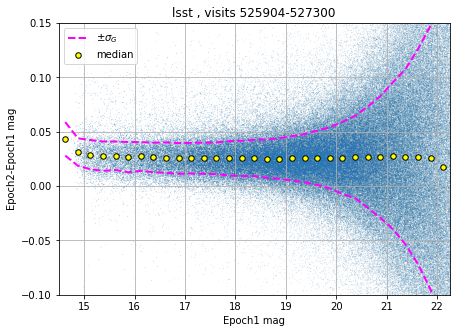

Comparing  525904  to  527300  of  decaps


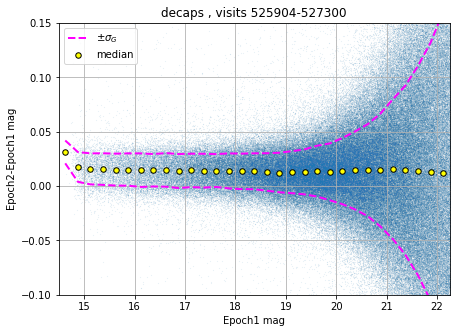

In [136]:
# Read-in cross-matched catalogs from various epochs 
#RMS : LSST_DECAPS comparison of the photometric scatter 
from astroML.stats._point_statistics import sigmaG
def plot_dmag(cat,ax,bins, source='lsst'):
    #bins = np.arange(14,23,0.5)
    mask_distance = cat['d2darcsec'].data < 0.5
    x = cat[mask_distance][source+'_mag_1']
    y = cat[mask_distance][source+'_mag_2']
    dm = y-x 
    
    # calculate the spread : sigmaG 
    spread_sig = bs(x,dm, bins=bins,statistic=sigmaG)
    sig = spread_sig.statistic

    # calculate the median per bin 
    median = bs(x,dm, bins=bins,statistic='median')
    med = median.statistic
    
    # from bin edges to bin_centers.... 
    bin_centers = (bins[:-1] + bins[1:])/2
    
    # plotting
    #fig,ax = plt.subplots(1,1)
    ax.scatter(x,y-x,s=0.001, label='')
    ax.set_xlim(bins[0], bins[-1])
    ax.set_ylim(-0.1, 0.15)
    ax.scatter(bin_centers , med ,s=30,c='yellow', edgecolors='k',
              label='median')
    ax.plot(bin_centers, med+sig, ls='--', lw=2, c='magenta', label=r'$\pm \sigma_{G}$')
    ax.plot(bin_centers, med-sig, ls='--', lw=2, c='magenta')
    ax.legend(loc='upper left')
    ax.set_xlabel('Epoch1 mag')
    ax.set_ylabel('Epoch2-Epoch1 mag')
    ax.grid()
    #ax.set_title(str(visit))
    #plt.savefig(str(visit)+'_half_arcsec_matches1.png', bbox_inches='tight')
    #plt.show()
%matplotlib inline    
bins = np.arange(14.5,22.5,0.25)
for pair in pairs[:1] : 
    print(pairs)
    visit1,visit2 = pair[0], pair[1]
    for source in ['lsst','decaps']:
        print('Comparing ', visit1, ' to ', visit2, ' of ', source )
        fname  = source+'-'+source+str(visit1)+'-'+str(visit2)+'.txt'
        cat = Table.read(fname, format='ascii')
        fig,ax= plt.subplots(1,1,figsize=(7,5))
        plot_dmag(cat,ax,bins, source=source)
        ax.set_title( source+' , visits '+str(visit1)+'-'+str(visit2))
        fname = source+'-'+source+str(visit1)+'-'+str(visit2) + '_dmag.png'
        plt.savefig( fname , bbox_inches='tight')
        plt.show()
# We positionally cross match DECAPS and LSST catalogs, and plot the 
# magnitude difference for objects within 0.5 arcsec from each other. 
# The median and sigmaG are calculated on full sample, i.e. 
# no clip on magnitude difference. 

# For completeness we also assumed that a match has to be within 
# 0.5 magnitude , but this does not affect median and sigmaG 
# which are not sensitive to rare outliers (objects 
# that are spatially close, but have a magnitude difference larger 
# than 0.5 magnitudes  )

In [140]:
from astropy.time import Time
mjd1 = Time(visit_info['mjd_obs_1'],format = 'mjd') 

In [147]:
visit_info['dmjd'] = visit_info['mjd_obs_2']-visit_info['mjd_obs_1']

In [151]:
visit_info['d2d_arcsec'] = visit_info['d2d_deg'] * 3600
visit_info['d2d_arcsec']

6.30037614517
4.81135220904
12.644452332
10.3141859148
7.95863749745
12.2892798802
19.1732985826
7.55842293056


In [153]:
visit_info_save = visit_info[['visit_1', 'ra_1','dec_1', 'magzero_1', 
            'visit_2','ra_2', 'dec_2', 'magzero_2',
           'd2d_arcsec', 'density', 'dmjd']]

In [154]:
visit_info_save.write('decaps_visits_epoch12.txt', format='latex')

[[525904, 527300], [525920, 527296], [525846, 530012], [525879, 530032], [525837, 527246], [525838, 527247], [525814, 529974], [525900, 529989]]
Comparing  525904  to  527300  of  lsst
[[525904, 527300], [525920, 527296], [525846, 530012], [525879, 530032], [525837, 527246], [525838, 527247], [525814, 529974], [525900, 529989]]
Comparing  525920  to  527296  of  lsst
[[525904, 527300], [525920, 527296], [525846, 530012], [525879, 530032], [525837, 527246], [525838, 527247], [525814, 529974], [525900, 529989]]
Comparing  525846  to  530012  of  lsst
[[525904, 527300], [525920, 527296], [525846, 530012], [525879, 530032], [525837, 527246], [525838, 527247], [525814, 529974], [525900, 529989]]
Comparing  525879  to  530032  of  lsst
[[525904, 527300], [525920, 527296], [525846, 530012], [525879, 530032], [525837, 527246], [525838, 527247], [525814, 529974], [525900, 529989]]
Comparing  525837  to  527246  of  lsst
[[525904, 527300], [525920, 527296], [525846, 530012], [525879, 530032], [5

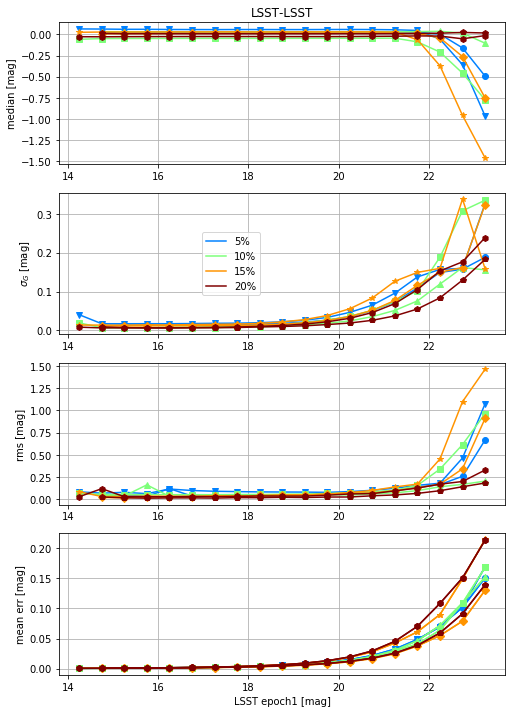

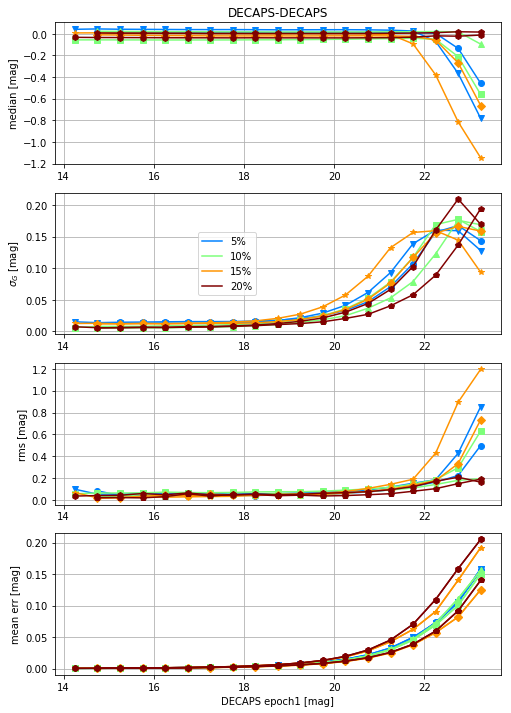

In [182]:
# Make a combined plot of rms for LSST-LSST,  
# and a separate plot of rms for DECAPS-DECAPS 
# calculate the spread : sigmaG

import matplotlib
import matplotlib.lines as mlines
def plot_dmag_epoch_stats(cat,ax,bins, density,color,marker,source='lsst'):
    mask_distance = cat['d2darcsec'].data < 0.5
    x = cat[mask_distance][source+'_mag_1']
    y = cat[mask_distance][source+'_mag_2']
    dm = y-x 
    e1 = cat[mask_distance][source+'_magerr_1']
    e2 = cat[mask_distance][source+'_magerr_1']
    
    # calculate the spread : sigmaG 
    spread_sig = bs(x,dm, bins=bins,statistic=sigmaG)
    sig = spread_sig.statistic
    
    # calculate the spread : rms
    rms_func = lambda x : np.sqrt(np.mean(np.square(x)))
    spread_rms = bs(x,dm, bins=bins,statistic=rms_func)
    rms = spread_rms.statistic

    # calculate the median per bin 
    median = bs(x,dm, bins=bins,statistic='median')
    med = median.statistic
    
    # calculate median error 
    median_error1 = bs(x,e1, bins=bins, statistic='median')
    median_error2 = bs(x,e2, bins=bins, statistic='median')
    
    # from bin edges to bin_centers.... 
    bin_centers = (bins[:-1] + bins[1:])/2
    
    # plotting
    #ax[0].scatter(bin_centers , med ,s=30, c=color)
    ax[0].plot(bin_centers , med, label=density, marker=marker, c=color)

    #ax[1].scatter(bin_centers,sig)
    ax[1].plot(bin_centers,sig,label=density,marker=marker, c=color)
    
    #ax[2].scatter(bin_centers, rms)
    ax[2].plot(bin_centers, rms, label=density,marker=marker, c=color)
    
    ax[3].plot(bin_centers, median_error1.statistic, 
               label=density, marker=marker, c=color)
    
    ax[3].plot(bin_centers, median_error2.statistic, 
               label=density, marker=marker, c=color)
    

cmap = matplotlib.cm.get_cmap('jet')
densities = list(visit_density_dic.keys())
markers = ['o','v', '^','s','D','*', 'h','p','X']
densities = np.array([5,10,15,20])
N = len(densities)
colors = (np.arange(len(densities))+1)/N

bins = np.arange(14.5,22.5,0.25)


for source in ['lsst','decaps']:
    # Plot all densities for given processing center on one panel : 
    fig, ax=  plt.subplots(4,1, figsize=(8,12))
    bins = np.arange(14,24,0.5)
    ax_legend_handles = []
    j = 0 
    for pair in pairs : 
        print(pairs)
        visit1,visit2 = pair[0], pair[1]
        print('Comparing ', visit1, ' to ', visit2, ' of ', source )
        density = visit_info[visit_info['visit_1'] == visit1]['density'][0]
        color = cmap(colors[densities == density][0])
        
        # want to add just one line per pair ... 
        # so check the remnant with division by 2 ...
        if j%2 == 0: 
            # add a line to the density legend... 
            density = str(density)
            line = mlines.Line2D([], [], color=color, label=density+'%')
            ax_legend_handles.append(line)
            
        # read the cross-matched catalog 
        fname  = source+'-'+source+str(visit1)+'-'+str(visit2)+'.txt'
        cat = Table.read(fname, format='ascii')
        
        marker = markers[j]
        plot_dmag_epoch_stats(cat,ax,bins, density,color,marker,source)
        j += 1 
        
    if source is 'lsst' : 
        title = 'LSST'
    else: 
        title = 'DECAPS'

    ax[0].set_title(title+'-'+title)

    ax[0].set_ylabel('median [mag]')
    #ax[0].set_ylim(-0.08, 0.1)

    ax[1].set_ylabel(r'$\sigma_{G}$ [mag]')
    #ax[1].set_ylim(-0.01,0.2)

    ax[2].set_ylabel('rms [mag]')
    #ax[2].set_ylim(0,0.6)

    ax[3].set_ylabel('mean err [mag]')

    ax[3].set_xlabel(title+' epoch1 [mag]')

    # put the legend outside the plot 
    # https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
    for i in range(len(ax)):
        ax[i].grid()

    ax[1].legend(handles = ax_legend_handles,
                 bbox_to_anchor=(0.31,0.5),
                  fancybox=True, loc="center left")

    plt.savefig(source+'-'+source+'_spread_plot.png', bbox_inches='tight')



In [179]:
len(pairs)

8

In [181]:
for i in range(len(pairs)):
    print(i%2)

0
1
0
1
0
1
0
1
